# Named Entity Recognition

This notebook is the same as `03-gmb-ner-bert.ipynb` but uses DistilBERT as the HuggingFace model instead.

The only change is in the declaration of the `MODEL_NAME`. This shows the power of using the HuggingFace API. You can experiment with fine-tuning multiple models without having to make significant changes to your application code.

## Environment Setup

In [1]:
!pip install transformers datasets seqeval

     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 325 kB 54.4 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 6.5 MB 45.8 MB/s 
     |████████████████████████████████| 895 kB 53.0 MB/s 
     |████████████████████████████████| 77 kB 2.1 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 1.1 MB 7.8 MB/s 
     |████████████████████████████████| 212 kB 55.2 MB/s 
     |████████████████████████████████| 136 kB 12.2 MB/s 
     |████████████████████████████████| 127 kB 61.7 MB/s 
     |████████████████████████████████| 271 kB 54.6 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 144 kB 51.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=b7fe197e07fa073b724535f6e50de3d0d6a15fa676b9a718fd8cfe5a7ca2c34a
  Stored in directory: /root/.cache/pip/whee

## Imports

In [2]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from seqeval.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn.functional import cross_entropy
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoConfig,
    DataCollatorForTokenClassification,
    get_scheduler
)

## Data Processing


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/odsc-2022-data/GMB/

bert-base-cased-gmb-ner        ner.csv		xlm-roberta-base-gmb-ner
distilbert-base-cased-gmb-ner  ner_dataset.csv


In [5]:
!head /content/drive/MyDrive/odsc-2022-data/GMB/ner_dataset.csv

Sentence #,Word,POS,Tag
Sentence: 1,Thousands,NNS,O
,of,IN,O
,demonstrators,NNS,O
,have,VBP,O
,marched,VBN,O
,through,IN,O
,London,NNP,B-geo
,to,TO,O
,protest,VB,O


In [6]:
GS_DATA_DIR = "/content/drive/MyDrive/odsc-2022-data/GMB/"
DATA_DIR = "data"

NER_FILEPATH = os.path.join(GS_DATA_DIR, "ner_dataset.csv")

OUTPUT_FILEPATHS = [
  os.path.join(DATA_DIR, "gmb-train.jsonl"),
  os.path.join(DATA_DIR, "gmb-valid.jsonl"),
  os.path.join(DATA_DIR, "gmb-test.jsonl")
]

# BASE_MODEL_NAME = "bert-base-cased"
BASE_MODEL_NAME = "distilbert-base-cased"
MODEL_DIR = os.path.join(DATA_DIR, "{:s}-gmb-ner".format(BASE_MODEL_NAME))

In [7]:
def write_output(tokens, labels, output_files, num_writter):
  assert(len(tokens) == len(labels))
  rec = json.dumps({ "tokens": tokens, "ner_tags": labels })
  dice = random.random()
  if dice <= 0.7:
    output_files[0].write("{:s}\n".format(rec))
    num_written[0] += 1
  elif dice <= 0.8:
    output_files[1].write("{:s}\n".format(rec))
    num_written[1] += 1
  else:
    output_files[2].write("{:s}\n".format(rec))
    num_written[2] += 1


os.makedirs(DATA_DIR, exist_ok=True)
output_files = [open(filepath, "w") for filepath in OUTPUT_FILEPATHS]
num_written = [0, 0, 0]
tokens, labels = [], []
with open(NER_FILEPATH, "r", encoding="latin-1") as fner:
  csv_reader = csv.reader(fner)
  next(csv_reader)  # skip header
  for row in csv_reader:
    if row[0].startswith("Sentence") and len(tokens) > 0:
      # write out current sentence to train / valid / test
      write_output(tokens, labels, output_files, num_written)
      tokens, labels = [], []
    # accumulate tokens and labels
    tokens.append(row[1])
    labels.append(row[3])
    # if num_written[0] > 1000:
    #   break

if len(tokens) > 0:
  write_output(tokens, labels, output_files, num_written)

[output_file.close() for output_file in output_files]
print(num_written)

[33461, 4831, 9667]


## Dataset

In [8]:
data_files = {
    "train": OUTPUT_FILEPATHS[0],
    "validation": OUTPUT_FILEPATHS[1],
    "test": OUTPUT_FILEPATHS[2]
}
gmb_dataset = load_dataset("json", data_files=data_files)
gmb_dataset

Using custom data configuration default-9f6a9421627757c9


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-9f6a9421627757c9/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 33461
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 4831
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 9667
    })
})

In [9]:
# gmb_dataset["train"][0]

## Distribution of Entity Types across splits


In [10]:
tag_freqs_by_split = defaultdict(Counter)
for split, dataset in gmb_dataset.items():
  for ner_tags in dataset["ner_tags"]:
    for tag in ner_tags:
      if tag.startswith("B-"):
        tag = tag.replace("B-", "")
        tag_freqs_by_split[split][tag] += 1
pd.DataFrame.from_dict(tag_freqs_by_split, orient="index")

,geo,gpe,per,org,tim,art,nat,eve
train,26325,11071,11758,13977,14266,258,132,210
validation,3840,1558,1767,2084,2010,51,20,37
test,7479,3241,3465,4082,4057,93,49,61


## Tokenization and Label Alignment

In [11]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [12]:
tokens = tokenizer(gmb_dataset["train"][0]["tokens"], is_split_into_words=True).tokens()
tokens

['[CLS]',
 'Thousands',
 'of',
 'demons',
 '##tra',
 '##tors',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.',
 '[SEP]']

In [13]:
input = tokenizer(gmb_dataset["train"][0]["tokens"], is_split_into_words=True)
word_ids = input.word_ids()
pd.DataFrame([tokens, word_ids], index=["tokens", "word_ids"])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
tokens,[CLS],Thousands,of,demons,##tra,##tors,have,marched,through,London,...,the,withdrawal,of,British,troops,from,that,country,.,[SEP]
word_ids,None,0,1,2,2,2,3,4,5,6,...,15,16,17,18,19,20,21,22,23,None


### Class Label Mappings

In [14]:
entity_types = set()
for ner_tags in gmb_dataset["train"]["ner_tags"]:
  for ner_tag in ner_tags:
    if ner_tag.startswith("B-"):
      entity_types.add(ner_tag.replace("B-", ""))
entity_types = sorted(list(entity_types))

tag_names = []
for entity_type in entity_types:
  tag_names.append("B-{:s}".format(entity_type))
  tag_names.append("I-{:s}".format(entity_type))
tag_names.append("O")

tags = ClassLabel(names=tag_names)
label2id = {name: tags.str2int(name) for name in tag_names}
id2label = {id: tags.int2str(id) for id in range(len(tag_names))}

# label2id, id2label

In [15]:
def tokenize_and_align_labels(examples):
  tokenized_inputs = tokenizer(examples["tokens"], 
                               truncation=True, 
                               is_split_into_words=True)
  aligned_batch_labels = []
  for idx, labels in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    prev_word_id = None
    aligned_labels = []
    for word_id in word_ids:
      if word_id is None or word_id == prev_word_id:
        aligned_labels.append(-100)   # IGNore tag
      else:
        aligned_labels.append(label2id[labels[word_id]])
      prev_word_id = word_id
    aligned_batch_labels.append(aligned_labels)
  tokenized_inputs["labels"] = aligned_batch_labels
  return tokenized_inputs


tokens = gmb_dataset["train"][0]["tokens"]
ner_tags = gmb_dataset["train"][0]["ner_tags"]
aligned_labels = tokenize_and_align_labels(gmb_dataset["train"][0:1])["labels"][0]
len(tokens), len(ner_tags), len(aligned_labels)

(24, 24, 28)

In [16]:
encoded_gmb_dataset = gmb_dataset.map(tokenize_and_align_labels,
                                      batched=True,
                                      remove_columns=["ner_tags", "tokens"])
encoded_gmb_dataset

  0%|          | 0/34 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 33461
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4831
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 9667
    })
})

## DataLoader

In [17]:
BATCH_SIZE = 24

In [18]:
collate_fn = DataCollatorForTokenClassification(tokenizer, padding="longest", return_tensors="pt")
train_dl = DataLoader(encoded_gmb_dataset["train"], shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_fn)
valid_dl = DataLoader(encoded_gmb_dataset["validation"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(encoded_gmb_dataset["test"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = AutoModelForTokenClassification.from_pretrained(BASE_MODEL_NAME,
                                                        num_labels=len(tag_names),
                                                        id2label=id2label,
                                                        label2id=label2id)
model = model.to(device)

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this 

## Training Loop

In [21]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-2
NUM_EPOCHS = 3

In [22]:
optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE,
                  weight_decay=WEIGHT_DECAY)

num_training_steps = NUM_EPOCHS * len(train_dl)
lr_scheduler = get_scheduler("linear",
                             optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

In [23]:
def align_predictions(labels_cpu, preds_cpu):
  # remove -100 labels from score computation
  batch_size, seq_len = preds_cpu.shape
  labels_list, preds_list = [], []
  for bid in range(batch_size):
    example_labels, example_preds = [], []
    for sid in range(seq_len):
      # ignore label -100
      if labels_cpu[bid, sid] != -100:
        example_labels.append(id2label[labels_cpu[bid, sid]])
        example_preds.append(id2label[preds_cpu[bid, sid]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return labels_list, preds_list


def compute_f1_score(labels, logits):
  # convert logits to predictions and move to CPU
  preds_cpu = torch.argmax(logits, dim=-1).cpu().numpy()
  labels_cpu = labels.cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)
  # seqeval.metrics.f1_score takes list of list of tags
  return f1_score(labels_list, preds_list)


# for batch in train_dl:
#   batch = {k: v.to(device) for k, v in batch.items()}
#   outputs = model(**batch)
#   break
# logits = outputs.logits
# labels = batch["labels"]
# print("labels.shape:", labels.size(), "logits.shape:", logits.size())
# score = compute_f1_score(labels, logits)
# print("f1-score:", score)

In [24]:
def do_train(model, train_dl):
  train_loss = 0
  model.train()
  for bid, batch in enumerate(train_dl):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)

    loss = outputs.loss
    train_loss += loss.detach().cpu().numpy()
    loss.backward()

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

  return train_loss


def do_eval(model, eval_dl):
  model.eval()
  eval_loss, eval_score, num_batches = 0, 0, 0
  for bid, batch in enumerate(eval_dl):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
      outputs = model(**batch)
    loss = outputs.loss

    eval_loss += loss.detach().cpu().numpy()
    eval_score += compute_f1_score(batch["labels"], outputs.logits)
    num_batches += 1

  eval_score /= num_batches

  return eval_loss, eval_score


def save_checkpoint(model, model_dir, epoch):
  model.save_pretrained(os.path.join(MODEL_DIR, "ckpt-{:d}".format(epoch)))


def save_training_history(history, model_dir, epoch):
  fhist = open(os.path.join(MODEL_DIR, "history.tsv"), "w")
  for epoch, train_loss, eval_loss, eval_score in history:
    fhist.write("{:d}\t{:.5f}\t{:.5f}\t{:.5f}\n".format(
        epoch, train_loss, eval_loss, eval_score))
  fhist.close()

## Training / Fine-tuning

In [25]:
if os.path.exists(MODEL_DIR):
  shutil.rmtree(MODEL_DIR)
  os.makedirs(MODEL_DIR)

history = []

for epoch in range(NUM_EPOCHS):
  train_loss = do_train(model, train_dl)
  eval_loss, eval_score = do_eval(model, valid_dl)
  history.append((epoch + 1, train_loss, eval_loss, eval_score))
  print("EPOCH {:d}, train loss: {:.3f}, val loss: {:.3f}, f1-score: {:.3f}".format(
      epoch, train_loss, eval_loss, eval_score))
  save_checkpoint(model, MODEL_DIR, epoch + 1)
  save_training_history(history, MODEL_DIR, epoch + 1)

EPOCH 0, train loss: 189.075, val loss: 19.410, f1-score: 0.821
EPOCH 1, train loss: 105.670, val loss: 18.124, f1-score: 0.823
EPOCH 2, train loss: 74.302, val loss: 18.690, f1-score: 0.833


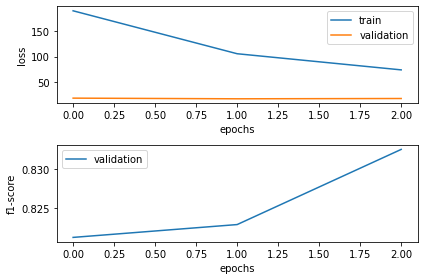

In [26]:
plt.subplot(2, 1, 1)
plt.plot([train_loss for _, train_loss, _, _ in history], label="train")
plt.plot([eval_loss for _, _, eval_loss, _ in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot([eval_score for _, _, _, eval_score in history], label="validation")
plt.xlabel("epochs")
plt.ylabel("f1-score")
plt.legend(loc="best")

plt.tight_layout()
_ = plt.show()

## Evaluation

In [27]:
def get_label_and_predicted_tags(batch):
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
  preds_cpu = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
  labels_cpu = batch["labels"].cpu().numpy()
  labels_list, preds_list = align_predictions(labels_cpu, preds_cpu)  
  return labels_list, preds_list


id2label[-100] = "IGN"
test_labels_list, test_preds_list = [], []
for batch in test_dl:
  labels_list, preds_list = get_label_and_predicted_tags(batch)
  for labels, preds in zip(labels_list, preds_list):
    test_labels_list.append(labels)
    test_preds_list.append(preds)

print(classification_report(test_labels_list, test_preds_list))

              precision    recall  f1-score   support

         art       0.30      0.17      0.22        93
         eve       0.30      0.28      0.29        61
         geo       0.85      0.92      0.88      7479
         gpe       0.96      0.94      0.95      3241
         nat       0.38      0.22      0.28        49
         org       0.72      0.68      0.70      4082
         per       0.77      0.79      0.78      3465
         tim       0.88      0.88      0.88      4057

   micro avg       0.83      0.84      0.84     22527
   macro avg       0.65      0.61      0.62     22527
weighted avg       0.83      0.84      0.84     22527



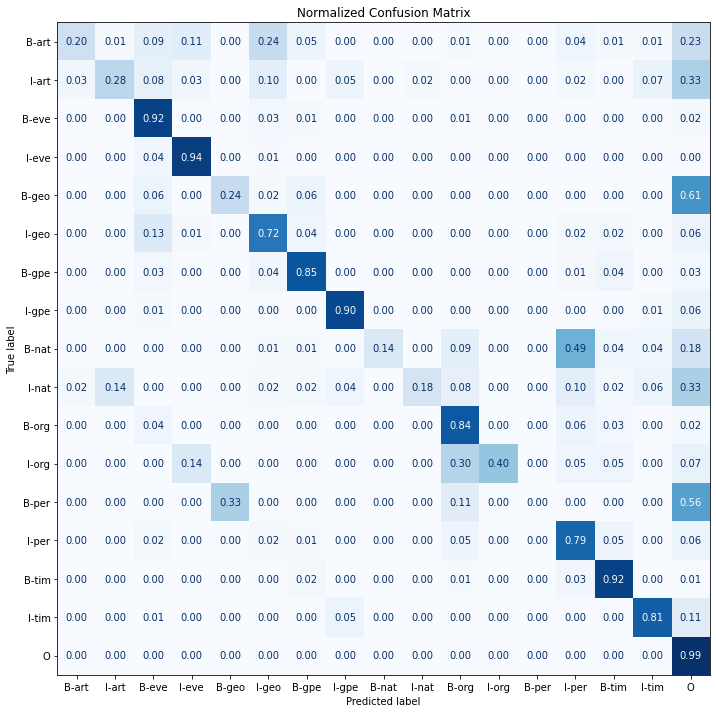

In [29]:
def plot_confusion_matrix(ytrue, ypreds, labels):
  cm = confusion_matrix(ytrue, ypreds, normalize="true")
  fig, ax = plt.subplots(figsize=(12, 12))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format="0.2f", ax=ax, colorbar=False)
  plt.title("Normalized Confusion Matrix")
  _ = plt.show()


flat_test_labels, flat_test_preds = [], []
for test_labels, test_preds in zip(test_labels_list, test_preds_list):
  flat_test_labels.extend(test_labels)
  flat_test_preds.extend(test_preds)
plot_confusion_matrix(flat_test_labels, flat_test_preds, tag_names)

## Usage

In [30]:
def align_tokens_and_predicted_labels(toks_cpu, preds_cpu):
  aligned_toks, aligned_preds = [], []
  prev_tok = None
  for tok, pred in zip(toks_cpu, preds_cpu):
    if tok.startswith("##") and prev_tok is not None:
      prev_tok += tok[2:]
    else:
      if prev_tok is not None:
        aligned_toks.append(prev_tok)
        aligned_preds.append(id2label[prev_pred])
      prev_tok = tok
      prev_pred = pred
  if prev_tok is not None:
    aligned_toks.append(prev_tok)
    aligned_preds.append(id2label[prev_pred])
  return aligned_toks, aligned_preds


def predict(texts):
  aligned_tok_list, aligned_pred_list = [], []
  for text in texts:
    inputs = tokenizer(text, return_tensors="pt").to(device)
    outputs = model(**inputs)
    tokens_cpu = tokenizer.convert_ids_to_tokens(inputs.input_ids.view(-1))
    preds_cpu = torch.argmax(outputs.logits, dim=-1)[0].cpu().numpy()

    aligned_toks, aligned_preds = align_tokens_and_predicted_labels(tokens_cpu, preds_cpu)

    aligned_tok_list.append(aligned_toks)
    aligned_pred_list.append(aligned_preds)

  return aligned_tok_list, aligned_pred_list


predicted_tokens, predicted_tags = predict([
         ["Marie Curie won the Nobel Prize in 1903 and 1911 ."],
         ["Joe Biden is the current President of the United States ."]
])

In [31]:
pd.DataFrame([predicted_tokens[0], predicted_tags[0]], index=["tokens", "predicted_tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
tokens,[CLS],Marie,Curie,won,the,Nobel,Prize,in,1903,and,1911,.,[SEP]
predicted_tags,O,B-per,I-per,O,O,B-org,I-org,O,B-tim,I-tim,I-tim,O,O


In [32]:
pd.DataFrame([predicted_tokens[1], predicted_tags[1]], index=["tokens", "predicted_tags"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
tokens,[CLS],Joe,Biden,is,the,current,President,of,the,United,States,.,[SEP]
predicted_tags,O,B-per,I-per,O,O,O,B-per,O,O,B-geo,I-geo,O,O


## Save Model

In [33]:
# !cp -r data/bert-base-cased-gmb-ner/ /content/drive/MyDrive/odsc-2022-data/GMB/
!cp -r data/distilbert-base-cased-gmb-ner/ /content/drive/MyDrive/odsc-2022-data/GMB/

In [34]:
# !ls /content/drive/MyDrive/odsc-2022-data/GMB/bert-base-cased-gmb-ner/
!ls /content/drive/MyDrive/odsc-2022-data/GMB/distilbert-base-cased-gmb-ner/

ckpt-1	ckpt-2	ckpt-3	history.tsv
